In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dataloader import *

In [2]:
import multiprocessing as mp

In [3]:
studies_project_files={p:f for p,f in data_files.items() if p in projects}

In [4]:
df = get_dataset(studies_project_files, True)
df.head()

,TC,TM,CUT,D,L,ABS,INT,JDK,ICB,DEP,...,TUAPI,UINT,SYNC,CALLSITES,AFPR,RBFA,EXPCAT,CONDCALL,PROJ,IS_MOCK
0,org.apache.hadoop.resourceestimator.translator...,testGetContainerSpec,org.apache.hadoop.resourceestimator.translator...,org.apache.hadoop.yarn.api.records.Resource,real,True,False,False,False,0.5,...,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,Hadoop,False
1,org.apache.hadoop.resourceestimator.translator...,testGetJobSize,org.apache.hadoop.resourceestimator.translator...,org.apache.hadoop.yarn.api.records.Resource,real,True,False,False,False,0.5,...,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,Hadoop,False
2,org.apache.hadoop.resourceestimator.translator...,testGetRecurrenceeId,org.apache.hadoop.resourceestimator.translator...,org.apache.hadoop.yarn.api.records.Resource,real,True,False,False,False,0.5,...,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,Hadoop,False
3,org.apache.hadoop.resourceestimator.translator...,testStringToUnixTimestamp,org.apache.hadoop.resourceestimator.translator...,org.apache.hadoop.yarn.api.records.Resource,real,True,False,False,False,0.5,...,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,Hadoop,False
4,org.apache.hadoop.resourceestimator.translator...,testResourceSkyline,org.apache.hadoop.resourceestimator.translator...,org.apache.hadoop.yarn.api.records.Resource,real,True,False,False,False,0.5,...,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,Hadoop,False


In [5]:

for f in feature_pp:
    df[f] = df[f] - df[f].min()

In [6]:
df['TC'].count()

546634

In [7]:
pd.DataFrame([
    {
        'PRIOJ': p,
        'TOTAL': df[(df['PROJ']==p)]['PROJ'].count(),
        'MOCK': df[(df['PROJ']==p) & df['IS_MOCK']]['PROJ'].count(),

    }
    for p in projects
])

,PRIOJ,TOTAL,MOCK
0,Hadoop,325335,14771
1,Flink,86758,7005
2,Hive,23565,1549
3,Camel,12962,1864
4,CXF,22622,1527
5,Druid,45508,1939
6,HBase,11990,1093
7,Dubbo,8678,788
8,Oozie,5568,279
9,Storm,3648,377


In [8]:
# df = df.drop(['PROJ'], axis = 1)
("%d mocks(%.2f%%)" % (df['IS_MOCK'].sum(), df['IS_MOCK'].sum()/df['IS_MOCK'].count()*100))

'31192 mocks(5.71%)'

# Correlation (balanced) 

In [9]:
def balance_dataset(dataset):
    mocked = dataset[dataset['IS_MOCK']]
    not_mocked = dataset[dataset['IS_MOCK']==False].sample(n=mocked['TC'].count())
    return pd.concat([mocked, not_mocked])

In [13]:
features = [
    "ABS",
    "INT",
    "JDK",
    "ICB",
    "DEP",
    "TDEP",
    "FIELD",
    "UAPI",
    "TUAPI",
    "UINT",
    "SYNC",
    "CALLSITES",
    "AFPR",
    "RBFA",
    "EXPCAT",
    "CONDCALL"
]

In [14]:
from sklearn.feature_selection import chi2

In [36]:
def _metric_core(x):
    data = x[0]
    metric_func = x[1]
    return metric_func(data[features], data['IS_MOCK'])

def feature_metric(dataset, metric):
    with mp.Pool(100) as pl:
        scores = pl.map(_metric_core, ((balance_dataset(dataset), metric) for i in range(100)))
        smean = np.mean(scores, axis=0)
        return {
            features[idx]: val
            for idx, val in enumerate(smean)
        }

In [37]:
def _chi2_core(x,y):
    return chi2(x,y)[0]

c2 = feature_metric(df, _chi2_core)

In [38]:
c2_df = pd.DataFrame([
    {
        'feature':f,
        'chi2': v
    }
    for f,v in c2.items()
]).sort_values('chi2', ascending=True)
c2_df

,feature,chi2
6,FIELD,8.464973
9,UINT,60.014189
7,UAPI,1035.857624
3,ICB,1281.752990
4,DEP,1490.049410
5,TDEP,2349.459690
0,ABS,2394.050086
1,INT,2506.895465
2,JDK,3103.922604
13,RBFA,3455.960077


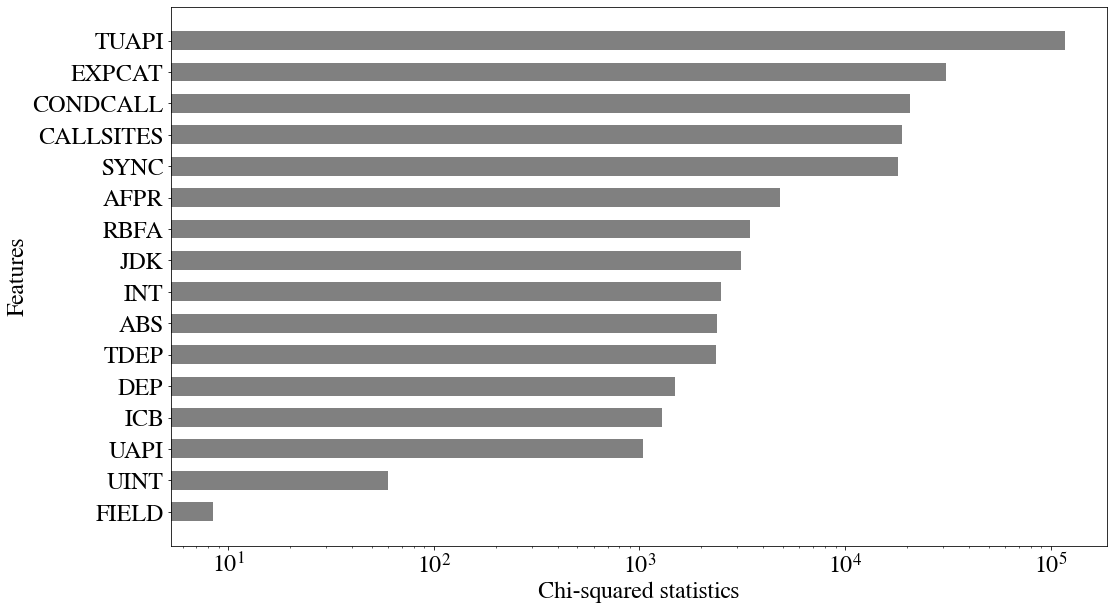

In [39]:
import matplotlib.style as style
# style.use('seaborn-paper')
# style.use('ggplot')

plt.rcParams.update({'font.family': 'FreeSerif'})
plt.rcParams.update({'font.size': 24})
fig, ax = plt.subplots(figsize=(16, 9))
ax.barh(y=c2_df['feature'], width=c2_df['chi2'], color="gray", height=0.6)
ax.set(xscale='log')
ax.set_xlabel('Chi-squared statistics')
ax.set_ylabel('Features')
plt.tight_layout()

In [19]:
# fig.savefig('chi2.pdf', dpi=300)

In [20]:
from classifier import *

In [21]:
def _model_core(p):
    train = p[0]
    test = p[1]
    f = p[2]
    X_train = train.drop(['IS_MOCK', 'TC', 'TM', 'DEP', 'L', 'PROJ'], axis=1)
    X_train = train[[f]]
    y_train = train['IS_MOCK']
    X_test = test[[f]]
    y_test = test['IS_MOCK']
    return run_classifier(X_train, X_test, y_train, y_test)

def run_intra_project(project_data, feature, pl, n_folds = 10, iter_count = 100):
    scores = []
    project_mocks = project_data[project_data['IS_MOCK']].sample(frac=1).reset_index(drop=True)
    project_not_mocks = project_data[~project_data['IS_MOCK']]
    fold_size = len(project_mocks)//n_folds
    for i in range(n_folds):
        tfidx = fold_size*i
        mock_train = pd.concat([project_mocks.iloc[0:tfidx], project_mocks.iloc[tfidx+fold_size:]])
        mock_test = project_mocks.iloc[tfidx:tfidx+fold_size]
        def _gen_data():
            train = pd.concat([
                mock_train,
                project_not_mocks.sample(n=fold_size*(n_folds-1))
            ])
            test = pd.concat([
                mock_test,
                project_not_mocks.sample(n=fold_size)
            ])
            return train, test, feature
        proj_score = pl.map_async(_model_core, [_gen_data() for n in range(iter_count)])
        scores.append(proj_score)
    return scores

In [22]:
training_data = get_dataset(studies_project_files, True)

In [23]:
pool = mp.Pool()

In [24]:
def pool_core_bal(par, f):
    project = par
    p = training_data[training_data['PROJ'] == project]
    return project, f, run_intra_project(p, f, pool)

tmp_result =[
    pool_core_bal(it, f)
    for it in projects 
    for f in features
]

In [25]:
runing_result = [
    (p, f, {
        k: np.mean([v[k] for s in r for v in s.get()])*100
        for k in metrics
    })
    for p, f, r in tmp_result
]

In [26]:
perf_df = pd.DataFrame([
    {
        'feature': f,
        'project': proj,
        **perf
    }
    for proj, f, perf in runing_result
])

In [27]:
perf_features = perf_df.groupby('feature').mean().sort_values('f1-score', ascending=False)
perf_features

,accuracy,precision,recall,f1-score
feature,,,,
DEP,71.314353,70.904254,73.429041,71.574676
FIELD,67.771528,64.555135,80.739192,71.185667
JDK,59.675797,55.721910,96.297577,70.520475
TDEP,68.909347,70.689108,65.670986,67.368846
TUAPI,65.734941,71.532703,66.329959,63.406250
ABS,60.561427,59.712389,68.818232,62.799971
ICB,60.142632,62.338109,55.696687,56.573745
INT,59.047188,61.412042,55.133700,56.139975
UAPI,62.919252,73.843893,52.664380,55.362069


In [28]:
perf_features.describe()

,accuracy,precision,recall,f1-score
count,16.000000,16.000000,16.000000,16.000000
mean,60.725990,65.699178,58.298693,55.569423
std,5.392923,5.405133,16.498105,11.331563
min,51.153483,55.721910,34.270486,36.620672
25%,58.244573,62.106592,46.845207,47.754598
50%,59.361492,64.554458,55.415194,55.751022
75%,63.623174,70.742895,66.952028,64.396899
max,71.314353,73.843893,96.297577,71.574676


In [41]:
table2 = perf_features.join(c2_df.set_index('feature')).sort_index()[['chi2','accuracy','precision','recall','f1-score']].round(2)
table2

,chi2,accuracy,precision,recall,f1-score
feature,,,,,
ABS,2394.05,60.56,59.71,68.82,62.80
AFPR,4835.57,56.76,63.99,39.54,43.31
CALLSITES,18996.25,57.72,63.94,49.31,49.11
CONDCALL,20728.24,58.53,64.55,45.56,49.15
DEP,1490.05,71.31,70.90,73.43,71.57
EXPCAT,30968.33,58.42,70.40,34.27,41.84
FIELD,8.46,67.77,64.56,80.74,71.19
ICB,1281.75,60.14,62.34,55.70,56.57
INT,2506.90,59.05,61.41,55.13,56.14


In [42]:
print(table2.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &       chi2 &  accuracy &  precision &  recall &  f1-score \\
feature   &            &           &            &         &           \\
\midrule
ABS       &    2394.05 &     60.56 &      59.71 &   68.82 &     62.80 \\
AFPR      &    4835.57 &     56.76 &      63.99 &   39.54 &     43.31 \\
CALLSITES &   18996.25 &     57.72 &      63.94 &   49.31 &     49.11 \\
CONDCALL  &   20728.24 &     58.53 &      64.55 &   45.56 &     49.15 \\
DEP       &    1490.05 &     71.31 &      70.90 &   73.43 &     71.57 \\
EXPCAT    &   30968.33 &     58.42 &      70.40 &   34.27 &     41.84 \\
FIELD     &       8.46 &     67.77 &      64.56 &   80.74 &     71.19 \\
ICB       &    1281.75 &     60.14 &      62.34 &   55.70 &     56.57 \\
INT       &    2506.90 &     59.05 &      61.41 &   55.13 &     56.14 \\
JDK       &    3103.92 &     59.68 &      55.72 &   96.30 &     70.52 \\
RBFA      &    3455.96 &     58.80 &      65.39 &   47.27 &     50.47 \\
SYNC      &   18

In [45]:
print(table2.describe().round(2).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &       chi2 &  accuracy &  precision &  recall &  f1-score \\
\midrule
count &      16.00 &     16.00 &      16.00 &   16.00 &     16.00 \\
mean  &   14287.82 &     60.73 &      65.70 &   58.30 &     55.57 \\
std   &   29018.77 &      5.39 &       5.40 &   16.50 &     11.33 \\
min   &       8.46 &     51.15 &      55.72 &   34.27 &     36.62 \\
25\%   &    1437.98 &     58.24 &      62.11 &   46.84 &     47.75 \\
50\%   &    2805.41 &     59.36 &      64.56 &   55.42 &     55.75 \\
75\%   &   18339.27 &     63.62 &      70.74 &   66.95 &     64.40 \\
max   &  117270.05 &     71.31 &      73.84 &   96.30 &     71.57 \\
\bottomrule
\end{tabular}

